#  <span style="color: blue;">人臉偵測與辨識 </span>

臉部辨識技術有越來越多的應用。這個單元將使用MTCNN模型來偵測人臉，用FaceNet提取臉部特徵，相關應用有：
 + 人臉身份驗証（確認是否為某人）(Face Authentication)
 + 人臉身份辨識（在多人中識別出是哪一個人）(Face Identification)
 + 人臉分群 (Face Cluster)
 + 人臉搜索 (Face Search)
 + 人臉追蹤 (Face Tracking)
 
不過，近來對生物特徵隱私權（如人臉特徵）的議題也越來越受重視，如下面報導。
+ <a href="https://udn.com/news/story/6811/4317212?from=udn-ch1_breaknews-1-0-news" target="_blank" title="生物特徵隱私權受矚">2020-02-02聯合報：生物特徵隱私權受矚</a>
+ <a href="https://udn.com/news/story/6812/4293443?from=udn-referralnews_ch2artbottom" target="_blank" title="生物特徵隱私權受矚">2020-01-17聯合報：歐盟公共場所擬禁臉部辨識3到5年</a>
+  <a href="https://www.youtube.com/watch?v=JhvhtzJAEDc" target="_blank" title="Facial recognition">Engadget, Facial recognition is everywhere, but are we ready for it?</a>



## MTCNN人臉偵測模型
+ 這個模型完成下面工作
  + 人臉偵測。
  + 找到準確的人臉框。
  + 會輸出左眼、右眼、鼻子、左嘴角、右嘴角等5個臉部地標點。
<pre>
[
{'box': [201, 83, 221, 289],
 'confidence': 0.9999898672103882,
 'keypoints': {
  'left_eye': (264, 201),
  'right_eye': (368, 204),
  'nose': (317, 267),
  'mouth_left': (273, 308),
  'mouth_right': (349, 314)}}
]
</pre>
+ 偵測步驟: 使用3個人工神經網路:P-Net、R-Net、O-Net分別進行下面工作:
     1. 使用P-Net找出一堆人臉候選框，並使用NMS(nonmaximum suppression)合併高度重疊之人臉候選框，然後進行步驟2。
     1. 使用R-Net刪除步驟1找到的錯誤候選框，並使用NMS合併高度重疊之人臉候選框。
     1. 使用O-Net刪除步驟2找到的錯誤候選框，使用NMS合併高度重疊之人臉候選框，並且找出5個臉部地標點。
<div>
    <img src="attachment:mtcnn.png" width="300">
</div>
+ K. Zhang, Z. Zhang, Z. Li and Y. Qiao, "Joint Face Detection and Alignment Using Multitask Cascaded Convolutional Networks," in IEEE Signal Processing Letters, vol. 23, no. 10, pp. 1499-1503, Oct. 2016.
<a href="http://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7553523&isnumber=7539715" target="_blank" title="MTCNN">doi: 10.1109/LSP.2016.2603342</a>
  + 安裝
  <pre>
  pip install mtcnn
  </pre>
  
  
## FaceNet人臉特徵提取模型
+ FaceNet對人臉影像提取用來度量人臉間相似度的表示特徵（一個128維度向量），此特徵表示又稱人臉嵌入(face embedding)。
+ 人臉嵌入具備有相似臉間距離小，不相同的臉間距離大的特性。 
<div>
    <img src="attachment:facenet.png" width="400">
</div>

+ 下面用的FaceNet是用<a href="https://www.microsoft.com/en-us/research/project/ms-celeb-1m-challenge-recognizing-one-million-celebrities-real-world/" target="_blank" title="MS-Celeb-1M dataset">MS-Celeb-1M dataset</a>這個資料集訓練出來的。
  + F. Schroff, D. Kalenichenko and J. Philbin, "FaceNet: A unified embedding for face recognition and clustering," 2015 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), Boston, MA, 2015, pp. 815-823. doi: 10.1109/CVPR.2015.7298682;<a href="https://arxiv.org/abs/1503.03832" target="_blank" title="FaceNet">arXiv:1503.03832</a>
+ <a href="https://machinelearningmastery.com/how-to-develop-a-face-recognition-system-using-facenet-in-keras-and-an-svm-classifier/" target="_blank" title="FaceNet">FaceNet使用範例</a>


In [1]:
# example of loading the keras facenet model
import tensorflow as tf
from tensorflow.keras.models import load_model
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import cv2
import numpy as np
import pickle
try:
    import mtcnn
except:
    !pip install mtcnn    
    import mtcnn
# print version to confirm that mtcnn was successfully installed
print(mtcnn.__version__)

# load the facenet model
_URL = 'https://github.com/satinder147/Attendance-using-Face/raw/master/facenet_keras.h5'
local_path_to_facenet_h5 = tf.keras.utils.get_file('facenet_keras.h5',origin=_URL,cache_subdir='models',extract=False)
facenet = load_model(local_path_to_facenet_h5)

# show the network architecture of facenet
facenet_arch = tf.keras.utils.plot_model(facenet, to_file='facenet.png',show_shapes=True, show_layer_names=True, dpi=64)
display(facenet_arch)
# create the mtcnn face detector
detector = mtcnn.MTCNN()

Output hidden; open in https://colab.research.google.com to view.

647168/637512 [==============================] - 0s 0us/step


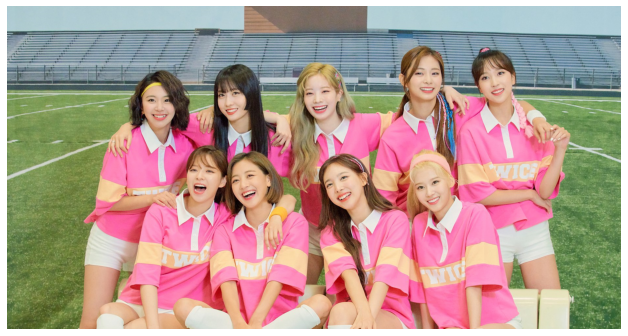

In [2]:
# load image from file
#url  ='https://www.teepr.com/wp-content/uploads/2019/07/%E8%9E%A2%E5%B9%95%E5%BF%AB%E7%85%A7-2019-07-15-%E4%B8%8B%E5%8D%883.42.39%E6%8B%B7%E8%B2%9D.jpg'
url  ='https://a.ksd-i.com/a/2020-01-01/123159-803538.jpg'
#url = 'http://img1.cache.netease.com/ent/2014/8/4/20140804091400aaef0_550.jpg'
name = url.split('/')[-1]
filename = tf.keras.utils.get_file(name,origin=url)
# 
image = tf.keras.preprocessing.image.load_img(filename)
# convert to array
pixels = tf.keras.preprocessing.image.img_to_array(image)

#show image
plt.figure(figsize=(pixels.shape[1]*6//pixels.shape[0],6))
plt.imshow(pixels/255)
plt.axis(False)
plt.show()

In [3]:
# detect faces in the image
results = detector.detect_faces(pixels)

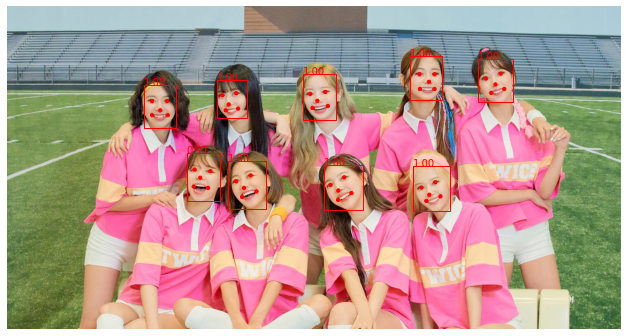

In [4]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# show detected faces
plt.figure(figsize=(pixels.shape[1]*6//pixels.shape[0],6))
plt.imshow(pixels/255)
plt.axis(False)
ax = plt.gca()

for b in results:
    x1, y1, width, height = b['box']
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    plt.text(x1,y1,'{:.2f}'.format(b['confidence']),color='red')
    ax.add_patch(mpatches.Rectangle((x1, y1),width, height, ec='red',alpha=1, fill=None))
    ax.add_patch(mpatches.Circle(b['keypoints']['mouth_left'],5,color='red'))
    ax.add_patch(mpatches.Circle(b['keypoints']['mouth_right'],5,color='red'))
    ax.add_patch(mpatches.Circle(b['keypoints']['left_eye'],5,color='red'))
    ax.add_patch(mpatches.Circle(b['keypoints']['right_eye'],5,color='red'))
    ax.add_patch(mpatches.Circle(b['keypoints']['nose'],5,color='red'))
plt.show()

In [5]:
def get_face_embedding(facenet,face_image):
    face_image = (face_image-tf.math.reduce_mean(face_image))/tf.math.reduce_std(face_image)
    embedding = facenet.predict(face_image[tf.newaxis,:])
    embedding = embedding/tf.norm(embedding)
    return embedding

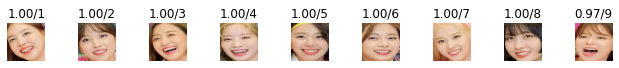

In [6]:
# extract detected faces and calculate the embedding
plt.figure(figsize=(10,(len(results)+9)//10))
face_embedding = []
face_img       = []
for idx,b in enumerate(results):
    plt.subplot((len(results)+9)//10,10,idx+1)
    x1, y1, width, height = b['box'] # 算左上角的點的位置
    x1, y1 = abs(x1), abs(y1) # 算長寬的長度
    x2, y2 = x1 + width, y1 + height # 算右上角的點的位置
    
    face = cv2.resize(pixels[y1:y2,x1:x2],(160,160)).astype('float32') 
    face_img.append(face)
    
    # get embedding
    embedding = get_face_embedding(facenet,face) # 收集臉部特徵
    face_embedding.append(embedding)
    
    plt.imshow(face_img[-1]/255)
    plt.title('{:.2f}/{}'.format(b['confidence'],idx+1)) # 輸出title: 信心度、第幾張圖片
    plt.axis(False)
plt.tight_layout()           
plt.show()

face_embedding = np.vstack(face_embedding) # np.vstack將array堆疊起來

### 人臉分群
使用Agglomerative Clustering搭配ward linkage，將人臉分三群。

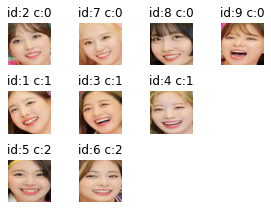

In [7]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(n_clusters=3).fit(face_embedding)

##顯示人臉分群結果
index = []
row   = [0]
for c in range(clustering.n_clusters_):
    idx = np.nonzero(clustering.labels_==c)[0]
    index.append(idx)
    row.append(row[-1]+(idx.size+9)//10)
total_rows = row[-1]

plt.figure(figsize=(10,total_rows))
for c in range(clustering.n_clusters_):
    for idx,face_id in enumerate(index[c]):
        plt.subplot(total_rows,10,row[c]*10+idx+1)
        plt.axis(False)
        plt.title('id:{} c:{}'.format(face_id+1,c))
        plt.imshow(face_img[face_id]/255)
plt.tight_layout()
plt.show()

### 人臉辨識
訓練人臉影像安排於如下資料匣，每個最底層(如ben_afflek)資料匣代表一個人(一類別)，內含這個人的影像。
<table style="width:600">
  <tr>
    <td align="center"><img src="attachment:train_folder.png" width="150"></td>
    <td align="text-align:left"><img src="attachment:train_folder_2.png" width="400"></td>
  </tr>
</table>

In [8]:
def generate_examples(gendata):
    train_x = []
    train_y = []
    for idx, (filename, y) in enumerate(zip(gendata.filenames,gendata.classes)):        
        x_img = tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(os.path.join(gendata.directory,filename)))
        results = detector.detect_faces(x_img)
        if len(results)>0:
            x1, y1, width, height = results[0]['box']
            x1, y1 = abs(x1), abs(y1)
            x2, y2 = x1 + width, y1 + height
            face = tf.image.resize(x_img[y1:y2,x1:x2],(160,160)) 
            embedding = get_face_embedding(facenet,face)
            train_x.append(embedding)
            train_y.append(y)
    return tf.concat(train_x,axis=0),tf.constant(np.array(train_y))

def def_face_recognition_model(class_indices):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input((128,)))
    model.add(tf.keras.layers.Dense(len(class_indices),activation='softmax'))        
    adam = tf.keras.optimizers.Adam()
    model.compile(loss='sparse_categorical_crossentropy',optimizer=adam,metrics=['accuracy'])
    model.person_name = {v:k for k,v in class_indices.items()}
    return model

def face_recognition(facenet,classifier,face_image):
    embedding = get_face_embedding(facenet,face_image)
    prob      = classifier.predict(embedding)
    name      = classifier.person_name[tf.math.argmax(prob,axis=1).numpy()[0]]      
    return name

In [9]:
! pip install -q kaggle
from google.colab import files
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/ # copy kaggle file to 

! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list


Saving kaggle.json to kaggle.json
ref                                                          title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
victorsoeiro/netflix-tv-shows-and-movies                     Netflix TV Shows and Movies                           2MB  2022-05-15 00:01:23           7339        226  1.0              
devansodariya/student-performance-data                       Student Performance Dataset                           7KB  2022-05-26 13:55:09           3173        127  0.9705882        
iamsouravbanerjee/software-professional-salaries-2022        Salary Dataset - 2022                               526KB  2022-06-10 06:02:59           1160         35  1.0              
paradisejoy/top-hits-spotify-from-2000201

In [10]:
print(os.listdir())

['.config', 'facenet.png', 'kaggle.json', 'sample_data']


In [61]:
current_dir_files_name = os.listdir()

HAVE_Dir = False
for file_name in current_dir_files_name:
    if "5-celebrity-faces-dataset" == file_name:
        HAVE_Dir = True

if (HAVE_Dir == False):
    !mkdir ./5-celebrity-faces-dataset/
    %cd 5-celebrity-faces-dataset
    !kaggle datasets download -d dansbecker/5-celebrity-faces-dataset
    
    import zipfile
    zf = zipfile.ZipFile("5-celebrity-faces-dataset.zip", 'r')
    zf.extractall()
    %cd ..
!ls

/content/5-celebrity-faces-dataset
  0% 0.00/5.03M [00:00<?, ?B/s]
100% 5.03M/5.03M [00:00<00:00, 142MB/s]
/content
5-celebrity-faces-dataset  face_model.pickle  kaggle.json
face_model.h5		   facenet.png	      sample_data


In [51]:
# Case1
# 將部分train data拆到 test 資料夾

# %cd 5-celebrity-faces-dataset

# !mkdir test

# !mkdir test/ben_afflek
# !mv train/ben_afflek/httpwwwhillsindcomstorebenjpg.jpg test/ben_afflek
# !mv train/ben_afflek/httpwwwrumenewscomwpcontentuploadsbenafflekxpng.jpg test/ben_afflek

# !mkdir test/elton_john
# !mv train/elton_john/httpwwwjohnpauljonesarenacomeventimagesEltonCalendarVjpg.jpg  test/elton_john
# !mv train/elton_john/httpwwwlautdeEltonJohneltonjohnjpg.jpg test/elton_john

# !mkdir test/jerry_seinfeld
# !mv train/jerry_seinfeld/httpwwwslatecomcontentdamslateblogsbrowbeatseinfeldjpgCROParticlemediumjpg.jpg test/jerry_seinfeld
# !mv train/jerry_seinfeld/httpwwwwatchidcomsitesdefaultfilesuploadsightingBreitlingwatchJerrySeinfeldjpg.jpg test/jerry_seinfeld

# !mkdir test/madonna
# !mv train/madonna/httpwwwblackdogfilmscomwordpresswpcontentuploadsmadonnacelebrationxjpg.jpg test/madonna
# !mv train/madonna/httpwwwetonlinecomphotomadonnabdayjpg.jpg test/madonna

# !mkdir test/mindy_kaling
# !mv train/mindy_kaling/httpwwwpictureszimbiocomfpMindyKalingfBgaONVFDFmjpg.jpg test/mindy_kaling
# !mv train/mindy_kaling/httpwwwpictureszimbiocomgiMindyKalingLkvEhTwDeJmjpg.jpg test/mindy_kaling

# %cd ..

/content/5-celebrity-faces-dataset
/content


In [41]:
# # Case2
# # 將部分val data拆到 test 資料夾

# %cd 5-celebrity-faces-dataset

# !mkdir test

# !mkdir test/ben_afflek
# !mv val/ben_afflek/httpcsvkmeuadecafjpg.jpg test/ben_afflek
# !mv val/ben_afflek/httpcsvkmeuaafdfjpg.jpg test/ben_afflek

# !mkdir test/elton_john
# !mv val/elton_john/httpcdncdnjustjaredcomwpcontentuploadsheadlineseltonjohnsupportsbrucejennerstransitiontowomanjpg.jpg  test/elton_john
# !mv val/elton_john/httpcdnlyricssongonlyricsnetwpcontentuploadsEltonJohnDiscographyCDreleasesjpg.jpg test/elton_john

# !mkdir test/jerry_seinfeld
# !mv val/jerry_seinfeld/httpcdncdnjustjaredcomwpcontentuploadsheadlinesjerryseinfeldmakesbrianwilliamsjokejpg.jpg test/jerry_seinfeld
# !mv val/jerry_seinfeld/httpcdnssninsidercomwpcontentuploadsjerryseinfeldxjpg.jpg test/jerry_seinfeld

# !mkdir test/madonna
# !mv val/madonna/httpcdnfuncheapcomwpcontentuploadsVOGUEjpg.jpg test/madonna
# !mv val/madonna/httpecximagesamazoncomimagesIfmaBKWLACULSRjpg.jpg test/madonna

# !mkdir test/mindy_kaling
# !mv val/mindy_kaling/httpcdnpastemagazinecomwwwarticlesmindyprojectjpg.jpg test/mindy_kaling
# !mv val/mindy_kaling/httpdbrbzkkbdsdcloudfrontnetwpcontentuploadsMindyKalingjpg.jpg test/mindy_kaling

# %cd ..

/content/5-celebrity-faces-dataset
/content


In [62]:
# Case3 train data與val每類各拆一筆當作test的資料

%cd 5-celebrity-faces-dataset

!mkdir test

!mkdir test/ben_afflek
!mv val/ben_afflek/httpcsvkmeuaafdfjpg.jpg test/ben_afflek
!mv train/ben_afflek/httpwwwrumenewscomwpcontentuploadsbenafflekxpng.jpg test/ben_afflek

!mkdir test/elton_john
!mv val/elton_john/httpcdncdnjustjaredcomwpcontentuploadsheadlineseltonjohnsupportsbrucejennerstransitiontowomanjpg.jpg  test/elton_john
!mv train/elton_john/httpwwwlautdeEltonJohneltonjohnjpg.jpg test/elton_john

!mkdir test/jerry_seinfeld
!mv val/jerry_seinfeld/httpcdncdnjustjaredcomwpcontentuploadsheadlinesjerryseinfeldmakesbrianwilliamsjokejpg.jpg test/jerry_seinfeld
!mv train/jerry_seinfeld/httpwwwwatchidcomsitesdefaultfilesuploadsightingBreitlingwatchJerrySeinfeldjpg.jpg test/jerry_seinfeld

!mkdir test/madonna
!mv val/madonna/httpcdnfuncheapcomwpcontentuploadsVOGUEjpg.jpg test/madonna
!mv train/madonna/httpwwwetonlinecomphotomadonnabdayjpg.jpg test/madonna

!mkdir test/mindy_kaling
!mv val/mindy_kaling/httpcdnpastemagazinecomwwwarticlesmindyprojectjpg.jpg test/mindy_kaling
!mv train/mindy_kaling/httpwwwpictureszimbiocomgiMindyKalingLkvEhTwDeJmjpg.jpg test/mindy_kaling

%cd ..

/content/5-celebrity-faces-dataset
/content


In [60]:
# colab 刪除資料夾
# import shutil

# ! ls
# shutil.rmtree('5-celebrity-faces-dataset/')
# ! ls

5-celebrity-faces-dataset  face_model.pickle  kaggle.json
face_model.h5		   facenet.png	      sample_data
face_model.h5  face_model.pickle  facenet.png  kaggle.json  sample_data


In [63]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

#訓練資料匣
dataset_folder = './5-celebrity-faces-dataset/'
#dataset_folder = './face/'
#train_generator = train_datagen.flow_from_directory('./5-celebrity-faces-dataset/train',batch_size=1)
#valid_generator = train_datagen.flow_from_directory('./5-celebrity-faces-dataset/val',batch_size=1)
train_generator = train_datagen.flow_from_directory(dataset_folder +'train',batch_size=1)
valid_generator = train_datagen.flow_from_directory(dataset_folder +'val',batch_size=1)
test_generator  = train_datagen.flow_from_directory(dataset_folder +'test',batch_size=1)

train_x,train_y = generate_examples(train_generator)
valid_x,valid_y = generate_examples(valid_generator)
test_x,test_y   = generate_examples(test_generator)

Found 88 images belonging to 5 classes.
Found 20 images belonging to 5 classes.
Found 10 images belonging to 5 classes.


In [64]:
print(train_y)

tf.Tensor(
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4], shape=(88,), dtype=int32)


In [65]:
model = def_face_recognition_model(train_generator.class_indices)
history = model.fit(train_x,train_y,batch_size=13,validation_data=(valid_x,valid_y),epochs=30,verbose=1)

Epoch 1/30
7/7 [==============================] - 0s 28ms/step - loss: 1.5964 - accuracy: 0.2045 - val_loss: 1.5697 - val_accuracy: 0.3000
Epoch 2/30
7/7 [==============================] - 0s 7ms/step - loss: 1.5566 - accuracy: 0.3864 - val_loss: 1.5313 - val_accuracy: 0.3500
Epoch 3/30
7/7 [==============================] - 0s 7ms/step - loss: 1.5192 - accuracy: 0.5000 - val_loss: 1.4940 - val_accuracy: 0.4000
Epoch 4/30
7/7 [==============================] - 0s 9ms/step - loss: 1.4818 - accuracy: 0.6023 - val_loss: 1.4574 - val_accuracy: 0.4500
Epoch 5/30
7/7 [==============================] - 0s 7ms/step - loss: 1.4455 - accuracy: 0.7159 - val_loss: 1.4214 - val_accuracy: 0.7000
Epoch 6/30
7/7 [==============================] - 0s 5ms/step - loss: 1.4099 - accuracy: 0.8750 - val_loss: 1.3860 - val_accuracy: 0.9000
Epoch 7/30
7/7 [==============================] - 0s 7ms/step - loss: 1.3744 - accuracy: 0.9318 - val_loss: 1.3516 - val_accuracy: 0.9500
Epoch 8/30
7/7 [=================

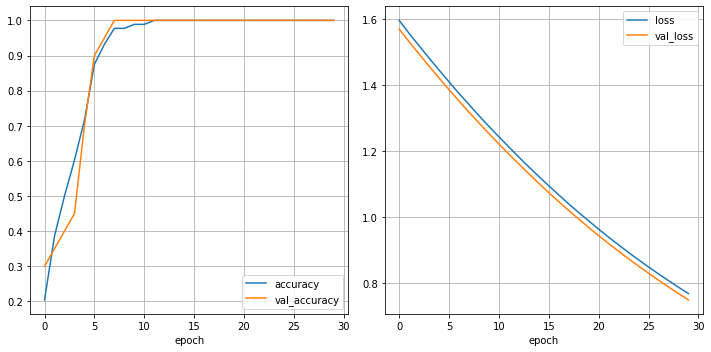

In [66]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.xlabel('epoch')
plt.grid(True)
plt.axis(True)
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
plt.grid(True)
plt.axis(True)
plt.xlabel('epoch')
plt.tight_layout()
plt.show()

#### 儲存模型
之後使用此模型只要載入即可，不需要再重新訓練。

In [20]:
model.save('face_model.h5')
with open('face_model.pickle','wb') as f:
    pickle.dump(model.person_name,f)

#### 載入模型

In [21]:
cmodel = tf.keras.models.load_model('face_model.h5')
with open('face_model.pickle','rb') as f:
    cmodel.person_name = pickle.load(f)

jerry_seinfeld


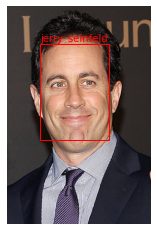

jerry_seinfeld


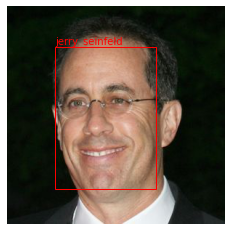

mindy_kaling


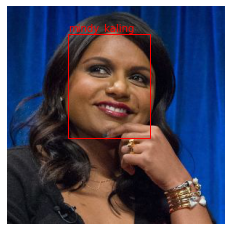

ben_afflek


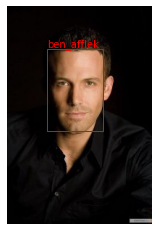

elton_john


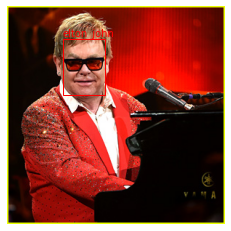

mindy_kaling


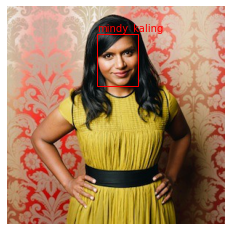

ben_afflek


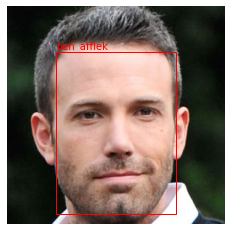

elton_john


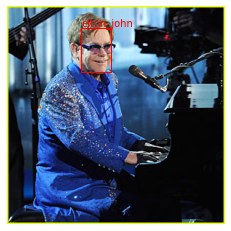

ben_afflek


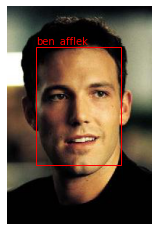

ben_afflek


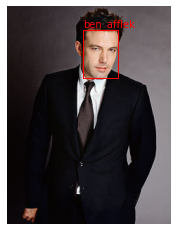

Correct rate: 100.0 %


In [96]:
import matplotlib.patches as mpatches

all_data_num = len(test_generator.filenames)
correct_data_num = 0

for r_idx in np.random.permutation(len(valid_generator.filenames))[:10]:
    
    #載入影像
    filename =valid_generator.filenames[r_idx]

    answer = filename.split('/')[0] # 標準答案
    print(answer) 

    x_img = tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(os.path.join(valid_generator.directory,filename)))
    plt.figure()
    ax = plt.gca()
    plt.imshow(x_img/255)

    #人臉偵測
    results = detector.detect_faces(x_img)
    
    #辨識人臉
    for b in results:
        x1, y1, width, height = b['box']
        x1, y1 = abs(x1), abs(y1)
        x2, y2 = x1 + width, y1 + height
        
        face      = tf.image.resize(x_img[y1:y2,x1:x2],(160,160)) 
        
        name      = face_recognition(facenet,cmodel,face)
        
        if(name == answer):
            correct_data_num += 1

        ax.add_patch(mpatches.Rectangle((x1, y1),width, height, ec='red',alpha=1, fill=None))
        plt.text(x1,y1-5, name,color='red')
        break # 原本支援一張圖片有多個人臉(但這邊break表示只有一個標準答案，不然算正確率會有問題)

    plt.axis(False)
    plt.show()

# 計算正確率
print(f"Correct rate: {correct_data_num/all_data_num * 100} %")

ben_afflek


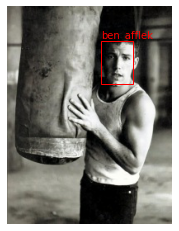

ben_afflek


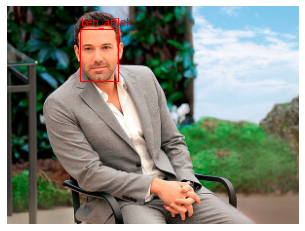

elton_john


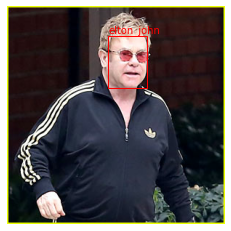

elton_john


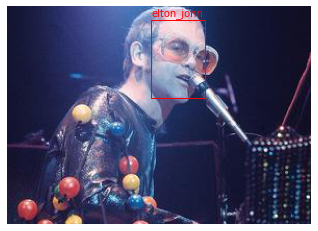

jerry_seinfeld


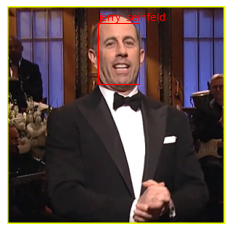

jerry_seinfeld


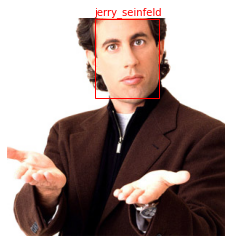

madonna


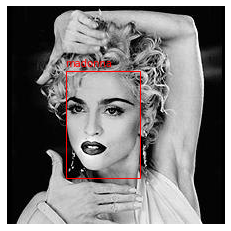

madonna


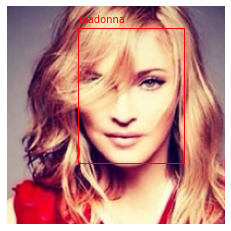

mindy_kaling


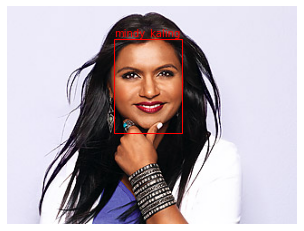

mindy_kaling


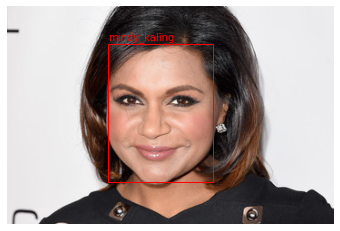

Correct rate: 100.0 %


In [93]:
import matplotlib.patches as mpatches

all_data_num = len(test_generator.filenames)
correct_data_num = 0

for r_idx in range(len(test_generator.filenames)):

    #載入影像
    filename =test_generator.filenames[r_idx]

    answer = filename.split('/')[0] # 標準答案
    print(answer) 
    
    x_img = tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(os.path.join(test_generator.directory,filename)))
    plt.figure()
    ax = plt.gca()
    plt.imshow(x_img/255)

    #人臉偵測
    results = detector.detect_faces(x_img)
    
    #辨識人臉
    for b in results:
        x1, y1, width, height = b['box']
        x1, y1 = abs(x1), abs(y1)
        x2, y2 = x1 + width, y1 + height
        
        face      = tf.image.resize(x_img[y1:y2,x1:x2],(160,160)) 
        
        name      = face_recognition(facenet,cmodel,face)
        
        if(name == answer):
            correct_data_num += 1

        ax.add_patch(mpatches.Rectangle((x1, y1),width, height, ec='red',alpha=1, fill=None))
        plt.text(x1,y1-5, name,color='red')
        break # 原本支援一張圖片有多個人臉(但這邊break表示只有一個標準答案，不然算正確率會有問題)
        
    plt.axis(False)
    plt.show()

# 計算正確率
print(f"Correct rate: {correct_data_num/all_data_num * 100} %")

In [23]:
%%html
<style>
@media print {
    a[href]::after {
        content: none !important;
    }
}
</style>